# MLWorkbench Magics

This notebook does the same thing as the previous notebook, but uses cloud services for each step. The goal is to show how the MLWorkbench magic are used differently when using ML Engine and other GCP products. This notebook does not cover MLWorkbench is detail--see the previous notebook--but points how what changes when running on the cloud. 

If you changed the WORKSPACE_PATH variable in the previous notebook, you must also change it here. If you made no modifications, there is no need to update the next cell. The previous notebook must be executed before this one.

In [6]:
WORKSPACE_PATH = '/content/workspace/text_classification_20newsgroup'

## What changes from local to cloud usage of the MLWorkbench magics?

Generally, a few things need to change:

* all data sources or file paths must be on GCS
* the --cloud flag must be set
* optional cloud_config values can be set

Other than this, nothing else changes from local to cloud!

# Step 1: Move the data to GCS

The csv files, and all input files to the MLWorkbench magics must exist on GCS first. Therefore the first step is to make a new GCS bucket and copy the local csv files to GCS. 


In [3]:
# Make a bucket name. This bucket name should not exist.
gcs_bucket = 'gs://tmp_datalab_mlworkbench_20news_sample' # Feel free to change this

The next two cells will make the bucket and copy the clean test and train csv files over

In [4]:
!gsutil mb $gcs_bucket

Creating gs://tmp_datalab_mlworkbench_20news_sample/...


In [8]:
!gsutil -m cp $WORKSPACE_PATH/news_clean_train.csv $WORKSPACE_PATH/news_clean_test.csv $gcs_bucket

Copying file:///content/workspace/text_classification_20newsgroup/news_clean_train.csv [Content-Type=text/csv]...
Copying file:///content/workspace/text_classification_20newsgroup/news_clean_test.csv [Content-Type=text/csv]...
- [2/2 files][ 10.7 MiB/ 10.7 MiB] 100% Done                                    
Operation completed over 2 objects/10.7 MiB.                                     


Check the files are on GCS

In [9]:
!gsutil ls $gcs_bucket

gs://tmp_datalab_mlworkbench_20news_sample/news_clean_test.csv
gs://tmp_datalab_mlworkbench_20news_sample/news_clean_train.csv


In [11]:
import google.datalab.contrib.mlworkbench.commands  # This loads the '%%ml' magics
import os

In [12]:
# Make some constant file paths

# Input files
train_csv_file = os.path.join(gcs_bucket, 'news_clean_train.csv')
eval_csv_file = os.path.join(gcs_bucket, 'news_clean_test.csv')

# For analyze step
analyze_output = os.path.join(gcs_bucket, 'analyze_output')

# For the transform step
transform_output = os.path.join(gcs_bucket, 'transform_output')
transformed_train_pattern = os.path.join(transform_output, 'features_train*')
transformed_eval_pattern = os.path.join(transform_output, 'features_eval*')

# For the training step
training_output = os.path.join(gcs_bucket, 'training_output')

# For the prediction steps
batch_predict_output = os.path.join(gcs_bucket, 'batch_predict_output')
evaluation_model = os.path.join(training_output, 'evaluation_model')
regular_model = os.path.join(training_output, 'model')

When we deploy the model, we will create a ML Engine model and two versions. Change the names below if desired. The model and version names should not exist.

In [55]:
mlengine_model_name = 'datalab_mlworkbench_20news_model'
evaluation_version = 'evaluation_version'
regular_version = 'v1'

full_evaluation_model_name = mlengine_model_name + '.' + evaluation_version
full_regular_model_name = mlengine_model_name + '.' + regular_version

# Step 2: Analyze the csv file
The csv data must be on GCS. We copied the data in the above cells. To run analyze in the cloud, the csv file must be on GCS and the --cloud flag must be used. Cloud analyze will use BigQuery as the backend.

In [14]:
%%ml analyze --cloud
output: $analyze_output
training_data:
  csv: $train_csv_file
  schema:
    - name: news_label
      type: STRING
    - name: text
      type: STRING
features:
  news_label:
    transform: target
  text:
    transform: bag_of_words

Analyzing column news_label...
column news_label analyzed.
Analyzing column text...
Updated property [core/project].
column text analyzed.
Updated property [core/project].


In [5]:
!ls $analyze_output

features.json  schema.json  stats.json	vocab_news_label.csv  vocab_text.csv


# Step 3: Transforming the input data

The output, analyze, and csv parameters must all be GCS paths. Unlike analyze, running the transform step using cloud services supports cloud options which are passed to the DataFlow job. run '%%ml transform --help' for a list of cloud options.

In [18]:
%%ml transform --shuffle --cloud
output: $transform_output
analysis: $analyze_output
prefix: features_train
training_data:
  csv: $train_csv_file
cloud_config:
  num_workers: 2

/usr/local/lib/python2.7/dist-packages/apache_beam/io/gcp/gcsio.py:113: DeprecationWarning: object() takes no parameters
  super(GcsIO, cls).__new__(cls, storage_client))
/usr/local/lib/python2.7/dist-packages/apache_beam/coders/typecoders.py:135: UserWarning: Using fallback coder for typehint: Any.
  warnings.warn('Using fallback coder for typehint: %r.' % typehint)
running sdist
running egg_info
creating trainer.egg-info
writing requirements to trainer.egg-info/requires.txt
writing trainer.egg-info/PKG-INFO
writing top-level names to trainer.egg-info/top_level.txt
writing dependency_links to trainer.egg-info/dependency_links.txt
writing manifest file 'trainer.egg-info/SOURCES.txt'
reading manifest file 'trainer.egg-info/SOURCES.txt'
writing manifest file 'trainer.egg-info/SOURCES.txt'

running check

creating trainer-1.0.0
creating trainer-1.0.0/trainer
creating trainer-1.0.0/trainer.egg-info
making hard links in trainer-1.0.0...
hard linking setup.py -> trainer-1.0.0
hard linking tr

Click the above link to see the dataflow job. Note that control went back to the notebook--you can run other cells--but the dataflow job is still running. The job will take about 5-10 minutes. It is up to you to wait for the job to finish before continuing this notebook.

We have to run transform on the eval set tool. Because the dataset is small, dataflow's startup time is larger than the time it takes to run the transformation. So we run the next cell locally. If you wish, add --cloud to the next cell to run another dataflow job. As all paths are on GCS, the output will be on GCS.

In [21]:
%%ml transform 
output: $transform_output
analysis: $analyze_output
prefix: features_eval
training_data:
  csv: $eval_csv_file

/usr/local/lib/python2.7/dist-packages/apache_beam/io/gcp/gcsio.py:113: DeprecationWarning: object() takes no parameters
  super(GcsIO, cls).__new__(cls, storage_client))
2017-07-12 20:55:16.399271: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2017-07-12 20:55:16.399309: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2017-07-12 20:55:16.399338: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
2017-07-12 20:55:16.399358: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX2 instructions, but these are a

Note how more than 1 file may have been made for training and eval. Sharding an input file can improve TensorFlow training performance, especially when running on a distributed cluster. 

In [23]:
!gsutil ls $transform_output



Updates are available for some Cloud SDK components.  To install them,
please run:
  $ gcloud components update

gs://tmp_datalab_mlworkbench_20news_sample/transform_output/errors_features_eval-00000-of-00001.txt
gs://tmp_datalab_mlworkbench_20news_sample/transform_output/errors_features_train-00000-of-00001.txt
gs://tmp_datalab_mlworkbench_20news_sample/transform_output/features_eval-00000-of-00008.tfrecord.gz
gs://tmp_datalab_mlworkbench_20news_sample/transform_output/features_eval-00001-of-00008.tfrecord.gz
gs://tmp_datalab_mlworkbench_20news_sample/transform_output/features_eval-00002-of-00008.tfrecord.gz
gs://tmp_datalab_mlworkbench_20news_sample/transform_output/features_eval-00003-of-00008.tfrecord.gz
gs://tmp_datalab_mlworkbench_20news_sample/transform_output/features_eval-00004-of-00008.tfrecord.gz
gs://tmp_datalab_mlworkbench_20news_sample/transform_output/features_eval-00005-of-00008.tfrecord.gz
gs://tmp_datalab_mlworkbench_20news_sample/transform_output/features_eval-0000

An errors file is always written, even if there are no errors. Let's check the error files are empty.

In [25]:
!gsutil ls -lh $transform_output/errors*

       0 B  2017-07-12T20:55:32Z  gs://tmp_datalab_mlworkbench_20news_sample/transform_output/errors_features_eval-00000-of-00001.txt
       0 B  2017-07-12T20:47:33Z  gs://tmp_datalab_mlworkbench_20news_sample/transform_output/errors_features_train-00000-of-00001.txt
TOTAL: 2 objects, 0 bytes (0 B)


# Step 4: Training a TensorFlow model
Again, see '%%ml train --help' for a list of cloud options. The cell below will run with default cloud options. Note that every file path must be a GCS path. You may want to change the cloud_config region value. Because the dataset is small, the cloud training will take more time than local training because of startup costs. It should take about 10 minutes.

In [40]:
# Training should use an empty output folder. So if you run training multiple times,
# use different folders or remove the output from the previous run.
!gsutil -m rm -fr $training_output

Removing gs://tmp_datalab_mlworkbench_20news_sample/training_output/schema_without_target.json#1499893542796098...
Removing gs://tmp_datalab_mlworkbench_20news_sample/training_output/staging/trainer.tar.gz#1499893526757242...
Removing gs://tmp_datalab_mlworkbench_20news_sample/training_output/train/#1499893545479107...
Removing gs://tmp_datalab_mlworkbench_20news_sample/training_output/train/events.out.tfevents.1499893545.a0c370500d77#1499893547316966...
/ [4 objects]                                                                   
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m -o ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Removing gs://tmp_datalab_mlworkbench_20news_sample/training_output/train/graph.pbtxt.tmp69bac5dd71ec45629c8a7b0a69c587ed#1499893548881225...
/ [5 objects]                                                     

In [45]:
%%ml train --cloud
output: $training_output
analysis: $analyze_output
training_data:
  transformed: $transformed_train_pattern
evaluation_data:
  transformed: $transformed_eval_pattern
model_args:
  l2-regularization: 5
  model: linear_classification
  top-n: 4
  learning-rate: 1
  max-steps: 5000
  train-batch-size: 500
  eval-batch-size: 500
  save-checkpoints-secs: 60
cloud_config:
  scale_tier: STANDARD_1
  region: us-central1
  runtime_version: '1.2'
    

Job "trainer_task_170712_212243" submitted. Click here to view cloud log.

It is up to you to wait for the training job to finish before continuing this notebook.

In [69]:
!gsutil ls  $training_output

gs://tmp_datalab_mlworkbench_20news_sample/training_output/schema_without_target.json
gs://tmp_datalab_mlworkbench_20news_sample/training_output/evaluation_model/
gs://tmp_datalab_mlworkbench_20news_sample/training_output/model/
gs://tmp_datalab_mlworkbench_20news_sample/training_output/staging/
gs://tmp_datalab_mlworkbench_20news_sample/training_output/train/


# Step 5: Deploying the model

See the previous notebook about the output models of training and the naming of ML Engine models. 

Below, we create a new ML Engine model, and two ML Engine model versions, one for each tensorflow model.

In [61]:
!gcloud ml-engine models create $mlengine_model_name --regions=us-central1

Created ml engine model [projects/cloud-ml-dev/models/datalab_mlworkbench_20news_model].


In [62]:
!gcloud ml-engine versions create $evaluation_version --model=$mlengine_model_name --origin=$evaluation_model --runtime-version=1.2

Creating version (this might take a few minutes)......done.


In [63]:
!gcloud ml-engine versions create $regular_version --model=$mlengine_model_name --origin=$regular_model --runtime-version=1.2

Creating version (this might take a few minutes)......done.


# Step 6: Evaluation using batch prediction

In the example below, we will run evaluation on the deployed evaluation model. Note the output and input file paths are on GCS. Also, model is not a path, it is the name of the deployed model.

In [67]:
%%ml batch_predict --cloud
model: $full_evaluation_model_name
output: $batch_predict_output
format: json
prediction_data:
  csv: $eval_csv_file
cloud_config:
  job_id: mlworkbench_batch_prediction_job_name_2
  region: us-central1

Job "mlworkbench_batch_prediction_job_name_2" submitted. Click here to view cloud log.

In [72]:
!gsutil ls -lh $batch_predict_output

       0 B  2017-07-12T22:39:09Z  gs://tmp_datalab_mlworkbench_20news_sample/batch_predict_output/prediction.errors_stats-00000-of-00001
   2.1 MiB  2017-07-12T22:39:30Z  gs://tmp_datalab_mlworkbench_20news_sample/batch_predict_output/prediction.results-00000-of-00001
TOTAL: 2 objects, 2205167 bytes (2.1 MiB)


In [64]:
!head -n 1 $batch_predict_output/predict_results_news_clean_test.json

{"score_2": 0.20030562579631805, "score_3": 0.07384685426950455, "score_4": 0.06857029348611832, "target": "rec.autos", "score": 0.35834765434265137, "predicted": "rec.autos", "predicted_2": "comp.sys.mac.hardware", "predicted_3": "rec.sport.baseball", "predicted_4": "soc.religion.christian"}


Because the data is small, we can open a file on GCS within python (by using a tensorflow file wrapper) and do analysis. For large data, it is recommended to load the predictions into a BigQuery table, and then use SQL. 

In [73]:
import json
from tensorflow.python.lib.io import file_io 

In [75]:
y_true = []
y_predicted = []
prediction_files = file_io.get_matching_files(os.path.join(batch_predict_output, 'prediction.results*'))
for prediction_file in prediction_files:
    with file_io.FileIO(prediction_file, 'r') as f:
        for line in f:
            jline = json.loads(line)
            y_predicted.append(jline['predicted'])
            y_true.append(jline['target'])

In [76]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools
classes = sorted(list(set(y_predicted + y_true)))
cm = confusion_matrix(y_true, y_predicted, classes)
print(classification_report(y_true, y_predicted, target_names=classes))

                          precision    recall  f1-score   support

             alt.atheism       0.43      0.42      0.42       319
           comp.graphics       0.57      0.64      0.60       389
 comp.os.ms-windows.misc       0.63      0.57      0.60       394
comp.sys.ibm.pc.hardware       0.62      0.56      0.59       392
   comp.sys.mac.hardware       0.66      0.60      0.63       385
          comp.windows.x       0.78      0.62      0.69       395
            misc.forsale       0.72      0.76      0.74       390
               rec.autos       0.59      0.64      0.62       396
         rec.motorcycles       0.55      0.70      0.61       398
      rec.sport.baseball       0.43      0.81      0.56       397
        rec.sport.hockey       0.89      0.81      0.85       399
               sci.crypt       0.82      0.60      0.69       396
         sci.electronics       0.47      0.52      0.49       393
                 sci.med       0.74      0.64      0.69       396
         

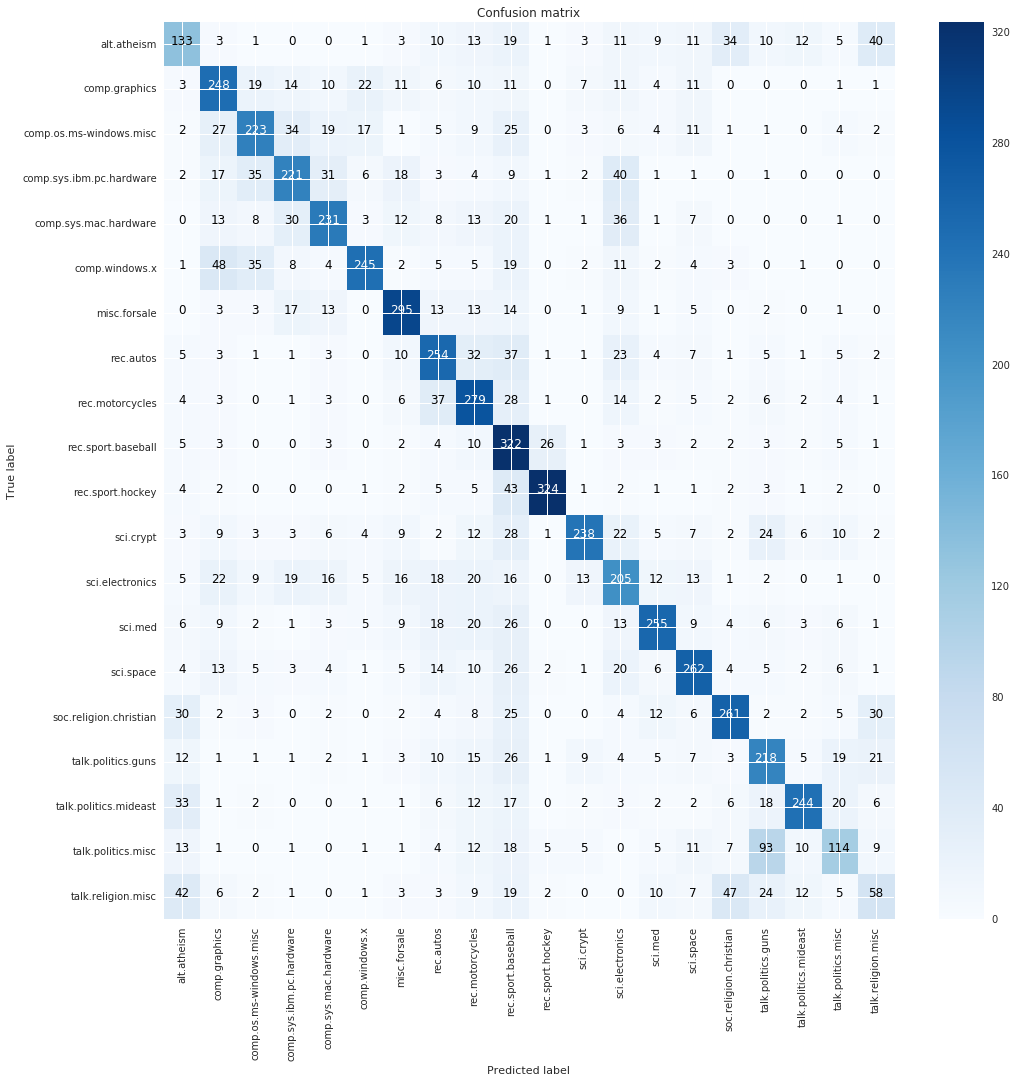

In [77]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    fig, ax = plt.subplots(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plot_confusion_matrix(cm, classes)    

# Step 7: Instant prediction



## Prediction within MLWorkbench

The MLWorkbench also supports running prediction on the deployed model directly.

In [80]:
%%ml predict --cloud
model: $full_regular_model_name
headers: text
prediction_data:
  - nasa
  - windows xp

predicted,predicted_2,predicted_3,predicted_4,score,score_2,score_3,score_4,text
sci.space,rec.motorcycles,rec.sport.baseball,rec.autos,0.129155,0.069474,0.068378,0.060507,nasa
comp.os.ms-windows.misc,comp.graphics,rec.motorcycles,comp.windows.x,0.200627,0.064402,0.064397,0.062812,windows xp


## Prediction from a python client

A common problem is to call a deployed model from different applications. Below is an example of writing a python client to run prediction outside of Datalab. 

Covering model permissions topics is outside the scope of this notebook, but for more information see https://cloud.google.com/ml-engine/docs/tutorials/python-guide and https://developers.google.com/identity/protocols/application-default-credentials .

In [81]:
# For this cell, we'll get the default project from Datalab, but for a true
# client, this value might be hard-coded.
import google.datalab
your_project_ID = google.datalab.Context.default().project_id

In [84]:
from oauth2client.client import GoogleCredentials
from googleapiclient import discovery
from googleapiclient import errors

# Store your project ID, model name, and version name in the format the API needs.
api_path = 'projects/{your_project_ID}/models/{model_name}/versions/{version_name}'.format(
    your_project_ID=your_project_ID,
    model_name=mlengine_model_name,
    version_name=regular_version)

# Get application default credentials (possible only if the gcloud tool is
#  configured on your machine). See https://developers.google.com/identity/protocols/application-default-credentials
#  for more info.
credentials = GoogleCredentials.get_application_default()

# Build a representation of the Cloud ML API.
ml = discovery.build('ml', 'v1', credentials=credentials)

# Create a dictionary containing data to predict.
# Note that the data is a list of csv strings.
body = {
    'instances': ['nasa',
                  'windows ex']}

# Create a request
request = ml.projects().predict(
    name=api_path,
    body=body)

print('The JSON request: \n')
print(request.to_json())

# Make the call.
try:
    response = request.execute()
    print('\nThe response:\n')
    print(json.dumps(response, indent=2))
except errors.HttpError, err:
    # Something went wrong, print out some information.
    print('There was an error. Check the details:')
    print(err._get_reason())

The JSON request: 

{"body": "{\"instances\": [\"nasa\", \"windows ex\"]}", "resumable_uri": null, "headers": {"content-type": "application/json", "accept-encoding": "gzip, deflate", "accept": "application/json", "user-agent": "google-api-python-client/1.5.1 (gzip)"}, "uri": "https://ml.googleapis.com/v1/projects/cloud-ml-dev/models/datalab_mlworkbench_20news_model/versions/v1:predict?alt=json", "resumable": null, "methodId": "ml.projects.predict", "body_size": 37, "resumable_progress": 0, "method": "POST", "_in_error_state": false, "response_callbacks": []}

The response:

{
  "predictions": [
    {
      "score_2": 0.06947407871484756, 
      "score_3": 0.06837809830904007, 
      "score_4": 0.06050673499703407, 
      "score": 0.1291547566652298, 
      "predicted": "sci.space", 
      "predicted_2": "rec.motorcycles", 
      "predicted_3": "rec.sport.baseball", 
      "predicted_4": "rec.autos"
    }, 
    {
      "score_2": 0.06186315789818764, 
      "score_3": 0.0600651502609252

# Step 7: Clean up

This section is optional. We will delete all the GCP resources and local files created in this sequence of notebooks. If you are not ready to delete anything, don't run any of the following cells.


Delete the deployed versions and model.

In [89]:
!gcloud ml-engine versions delete $regular_version --model=$mlengine_model_name --quiet

Deleting version [v1]......done.


In [90]:
!gcloud ml-engine versions delete $evaluation_version --model=$mlengine_model_name --quiet

Deleting version [evaluation_version]......done.


In [92]:
!gcloud ml-engine models delete $mlengine_model_name --quiet

Deleting model [datalab_mlworkbench_20news_model]...done.


In [ ]:
Delete the files in the GCS bucket, and delete the bucket

In [ ]:
!gsutil -m rm -r $gcs_bucket

Remove the local files from the previous notebooks

In [95]:
!rm -fr $WORKSPACE_PATH